In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

import xcompare as xc
import momlevel
import os

import gsw
#import gsw_xarray as gsw # Wrapper for gsw that adds CF attributes

import matplotlib.pyplot as plt
%matplotlib inline

Schmidtko et al. (2014): 
**ASBW** is defined using the deepest measurement in profiles within *30 m* of the bottom, or, in the absence of CTD altimeter data, within 150m of the ETOPO-1 bathymetry. **ASBW** data are mapped onto a 0.25$^{\circ}\times$0.125$^{\circ}$ grid for bathymetry shallower than *1500 m*. Data is from the period **1975–2012** for selected areas around Antarctica.

In [3]:
deptho_max = 1500
north = -60.0

In [4]:
shlf_mask = xr.open_dataset('/work/jet/rlb_masks/CM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)
#shlf_mask = xr.open_dataset('/work/jet/rlb_masks/ESM4_1000m_Isobath_Contour_Transport_Masks.nc')\

In [5]:
pp = 'ocean_annual_z'
tprd = '1941-1969'
var = 'so' # so, thetao
yr = None # '0050' # None 

# Pick simulation/observation to compare against (only one entry allowed)
mod_ctr = 'Schmidtko' # CM4_piControl_c192_OM4p125_v7, CM4_piControl_C

# Pick simulation(s) to compare control
mods = ['CM4_historical_c192_OM4p125', 'CM4_historical_c192_OM4p25']
#['CM4_piControl_c192_OM4p125_v7','CM4_piControl_c192_OM4p25_v7', 'CM4_piControl_c192_OM4p25_v7_npolefix', 'CM4_piControl_C'] 
# ['CM4_piControl_c192_OM4p125_v6_alt1', 'CM4_piControl_C']

# ['CM4_piControl_c192_OM4p125_v6_alt1', 'CM4_piControl_C', 'Schmidtko']
mods.insert(0,mod_ctr)

teos10 = True

In [6]:
ddict = {mod:{} for mod in mods}
for mod in ddict:
    print('\n',mod)
    
    if mod not in ['WOA13','Schmidtko']:
        pp_dir = '/pp/%s/ts/annual/10yr/'%pp
        
        if mod=='CM4_historical_c192_OM4p125':
            rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/'
            platform = 'gfdl.ncrc5-intel22-prod-openmp'
        else:
            platform = 'gfdl.ncrc4-intel18-prod-openmp'
            if mod in ['CM4_ssp585_c192_OM4p25','CM4_historical_c192_OM4p25','CM4_piControl_c192_OM4p25_v8']:
                rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/'
            elif mod=='CM4_piControl_c192_OM4p25':
                rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/'
            else:
                rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/' 
            
        full_path = '/home/Jan-erik.Tesdal/data/raw/%s/ocean_annual_z/'%mod if mod in ['CM4_piControl_C','ESM4_piControl_D'] \
                else rootdir+'%s/'%mod+platform+pp_dir
        if int(tprd[-4:])-int(tprd[:4])+1 == 10:
            tprd_str = tprd[:3]+'*' if mod in ['CM4_piControl_C','CM4_piControl_C_doublediff'] else tprd
        elif int(tprd[-4:])-int(tprd[:4])+1 == 5:
            tprd_str = tprd
        else:
            if tprd[-4:-2]==tprd[:2]:
                tprd_str = tprd[:2]+'*'
            else:
                tprd_str = '*'
        data_path = full_path+pp+'.'+tprd_str+'.'+var+'.nc'
        print(data_path)
    elif mod=='Schmidtko':
        data_path = '/work/jet/Schmidtko_Antarctic_shelf_data.nc'
        print(data_path)

    vars_ds = xr.open_mfdataset(data_path,use_cftime=True) if mod not in ['WOA13','Schmidtko'] \
                else xr.open_dataset(data_path,decode_times=False)
    
    if mod not in ['WOA13','Schmidtko']:
        print(str(vars_ds.time.values[0])[:10],'to',str(vars_ds.time.values[-1])[:10])
    
    if mod not in ['WOA13','Schmidtko']:
        grid_path = os.path.sep.join(full_path.split(os.path.sep)[:-2])+'/ocean_monthly/ocean_monthly.static.nc' \
                        if mod in ['CM4_piControl_C','ESM4_piControl_D'] \
                    else os.path.sep.join(full_path.split(os.path.sep)[:-4])+'/'+pp+'.static.nc'
        print(grid_path)
        grid_ds = xr.open_dataset(grid_path,use_cftime=True)
        #print(grid_ds)
        
        if teos10:
            print('Calculate TEOS-10 Absolute salinity / Conservative Temperature')
            p = xr.apply_ufunc(gsw.p_from_z, -vars_ds['z_l'], grid_ds['geolat'], 0, 0, dask='parallelized')
            sa = xr.apply_ufunc(gsw.SA_from_SP, vars_ds.so, p, grid_ds['geolon'], grid_ds['geolat'], dask='parallelized')
            if var=='so':
                da = sa
            else:
                da = xr.apply_ufunc(gsw.CT_from_t, sa, vars_ds.thetao, p, dask='parallelized')
            
            if yr is None:
                print('Calculate temporal mean')
                if '*' in tprd_str:
                    print('Subselect years '+tprd[:4]+' to '+tprd[-4:])
                    print(str(da.sel(time=slice(tprd[:4],tprd[-4:])).time.values[0])[:10],'to',
                          str(da.sel(time=slice(tprd[:4],tprd[-4:])).time.values[-1])[:10])   
                    arr = da.chunk({'time':1}).ffill('z_l').isel(z_l=-1).sel(time=slice(tprd[:4],tprd[-4:]))\
                            .mean('time').where(grid_ds.geolat<north).where(grid_ds.deptho<deptho_max).rename(var)
                else:
                    print(str(da.time.values[0])[:10],'to',str(da.time.values[-1])[:10])
                    arr = da.chunk({'time':1}).ffill('z_l').isel(z_l=-1).mean('time')\
                            .where(grid_ds.geolat<north).where(grid_ds.deptho<deptho_max).rename(var)
            else:
                arr = da.chunk({'time':1}).ffill('z_l').isel(z_l=-1).sel(time=yr).squeeze()\
                        .where(grid_ds.geolat<north).where(grid_ds.deptho<deptho_max).rename(var)
                
        else:
            print('Use model output so / thetao')
            if yr is None:
                print('Calculate temporal mean')
                if '*' in tprd_str:
                    print('Subselect years '+tprd[:4]+' to '+tprd[-4:])
                    print(str(vars_ds[var].sel(time=slice(tprd[:4],tprd[-4:])).time.values[0])[:10],'to',
                          str(vars_ds[var].sel(time=slice(tprd[:4],tprd[-4:])).time.values[-1])[:10])  
                    arr = vars_ds[var].chunk({'time':1}).ffill('z_l').isel(z_l=-1).sel(time=slice(tprd[:4],tprd[-4:]))\
                            .mean('time').where(grid_ds.geolat<north).where(grid_ds.deptho<deptho_max)
                else:
                    print(str(vars_ds[var].time.values[0])[:10],'to',str(vars_ds[var].time.values[-1])[:10])
                    arr = vars_ds[var].chunk({'time':1}).ffill('z_l').isel(z_l=-1).mean('time')\
                            .where(grid_ds.geolat<north).where(grid_ds.deptho<deptho_max)
            else:
                arr = vars_ds[var].chunk({'time':1}).ffill('z_l').isel(z_l=-1).sel(time=yr).squeeze()\
                        .where(grid_ds.geolat<north).where(grid_ds.deptho<deptho_max)
                
        arr = xc.coord_util.associate_ocean_coords(arr,grid_ds)
        
    elif mod=='Schmidtko':
        arr = vars_ds['sa' if var=='so' else 'ct'].rename(var)

        
    ddict[mod] = arr.to_dataset()


 Schmidtko
/work/jet/Schmidtko_Antarctic_shelf_data.nc

 CM4_historical_c192_OM4p125
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/ocean_annual_z.19*.so.nc
1900-07-02 to 1979-07-02
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc
Calculate TEOS-10 Absolute salinity / Conservative Temperature
Calculate temporal mean
Subselect years 1941 to 1969
1941-07-02 to 1969-07-02

 CM4_historical_c192_OM4p25
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/ocean_annual_z.19*.so.nc
1900-07-02 to 1999-07-02
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc
Calculate TEOS-10 Absolute salinity / 

In [7]:
ddict_diff = {mod:{} for mod in list(ddict)[1:]}
for mod in ddict_diff:
    print(mod)
    ddict_diff[mod] = xc.compare_datasets(ddict[mod_ctr],ddict[mod],varlist=[var])

CM4_historical_c192_OM4p125
CM4_historical_c192_OM4p25


In [8]:
import cartopy
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from plot import get_so_map_boundary
circle = get_so_map_boundary()

In [9]:
from mplsettings import setup_plots
setup_plots()

### Two-panel figure

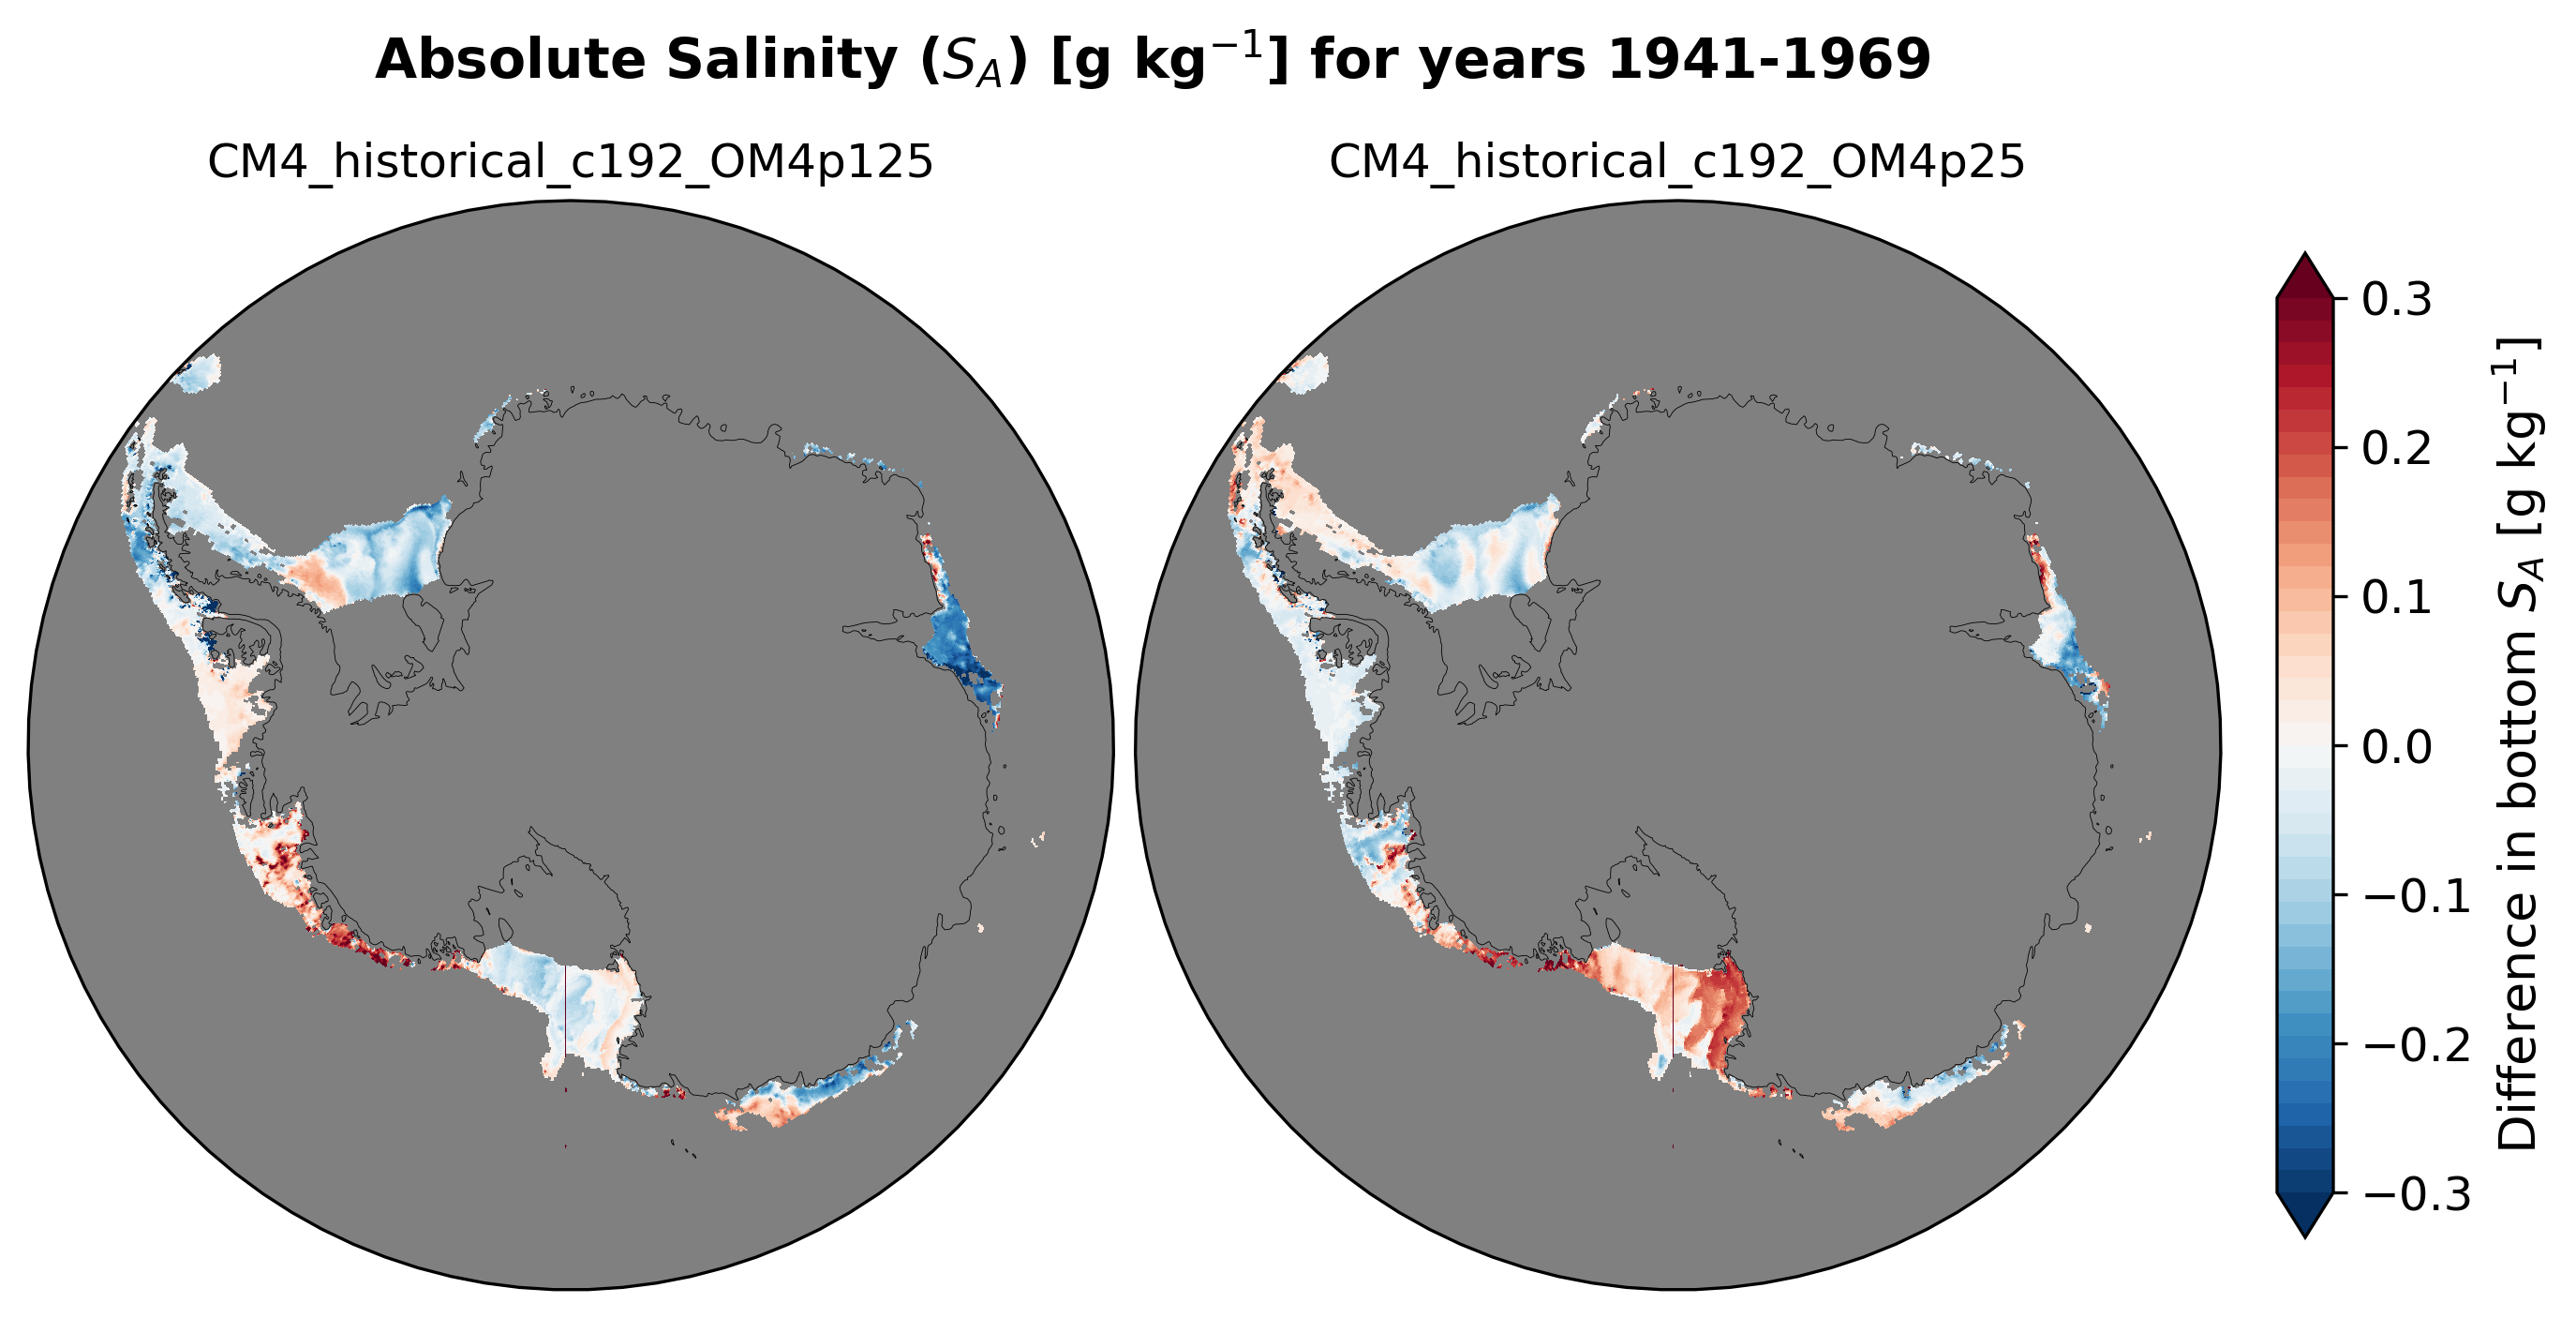

In [10]:
if var == 'so':
    titel_str = 'Absolute Salinity ($S_{A}$) [g kg$^{-1}$] for years %s'%(tprd if yr is None else yr)
    cb_str = '$S_{A}$ [g kg$^{-1}$]'
    vrange = [-0.3,0.3]
    ticks = np.arange(-0.5,0.6,0.1)
else:
    titel_str = 'Bottom temperature ($\Theta$) [$^{\circ}$C] for years %s'%(tprd if yr is None else yr)
    cb_str = '$\Theta$ [$^{\circ}$C]'
    vrange = [-2,2]
    ticks = np.arange(-2,2.5,0.5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), 
                         subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                         facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)
fig.suptitle(titel_str,fontweight='bold',fontsize=14,y=1.01)

for i, mod in enumerate(ddict_diff):
    
    #da = ddict_diff[mod]['diff'][var]
    da = ddict_diff[mod]['diff'][var]*(-1) # map differences as mod minus obs
    axes[i].coastlines(lw=0.2)
    axes[i].set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
    axes[i].set_boundary(circle, transform=axes[i].transAxes)
    p = da.plot(ax=axes[i], x='lon', y='lat', cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1], levels=41, 
                shading='auto',extend='both',transform=cartopy.crs.PlateCarree(), add_colorbar=False)
    axes[i].set_title(mod, fontsize=12)

cax = fig.add_axes([0.9, 0.15 , 0.02, 0.7])
cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=ticks, shrink=0.5, pad=0.2)
cb.set_label('Difference in bottom '+cb_str, fontsize=13)
cb.ax.tick_params(labelsize=12)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

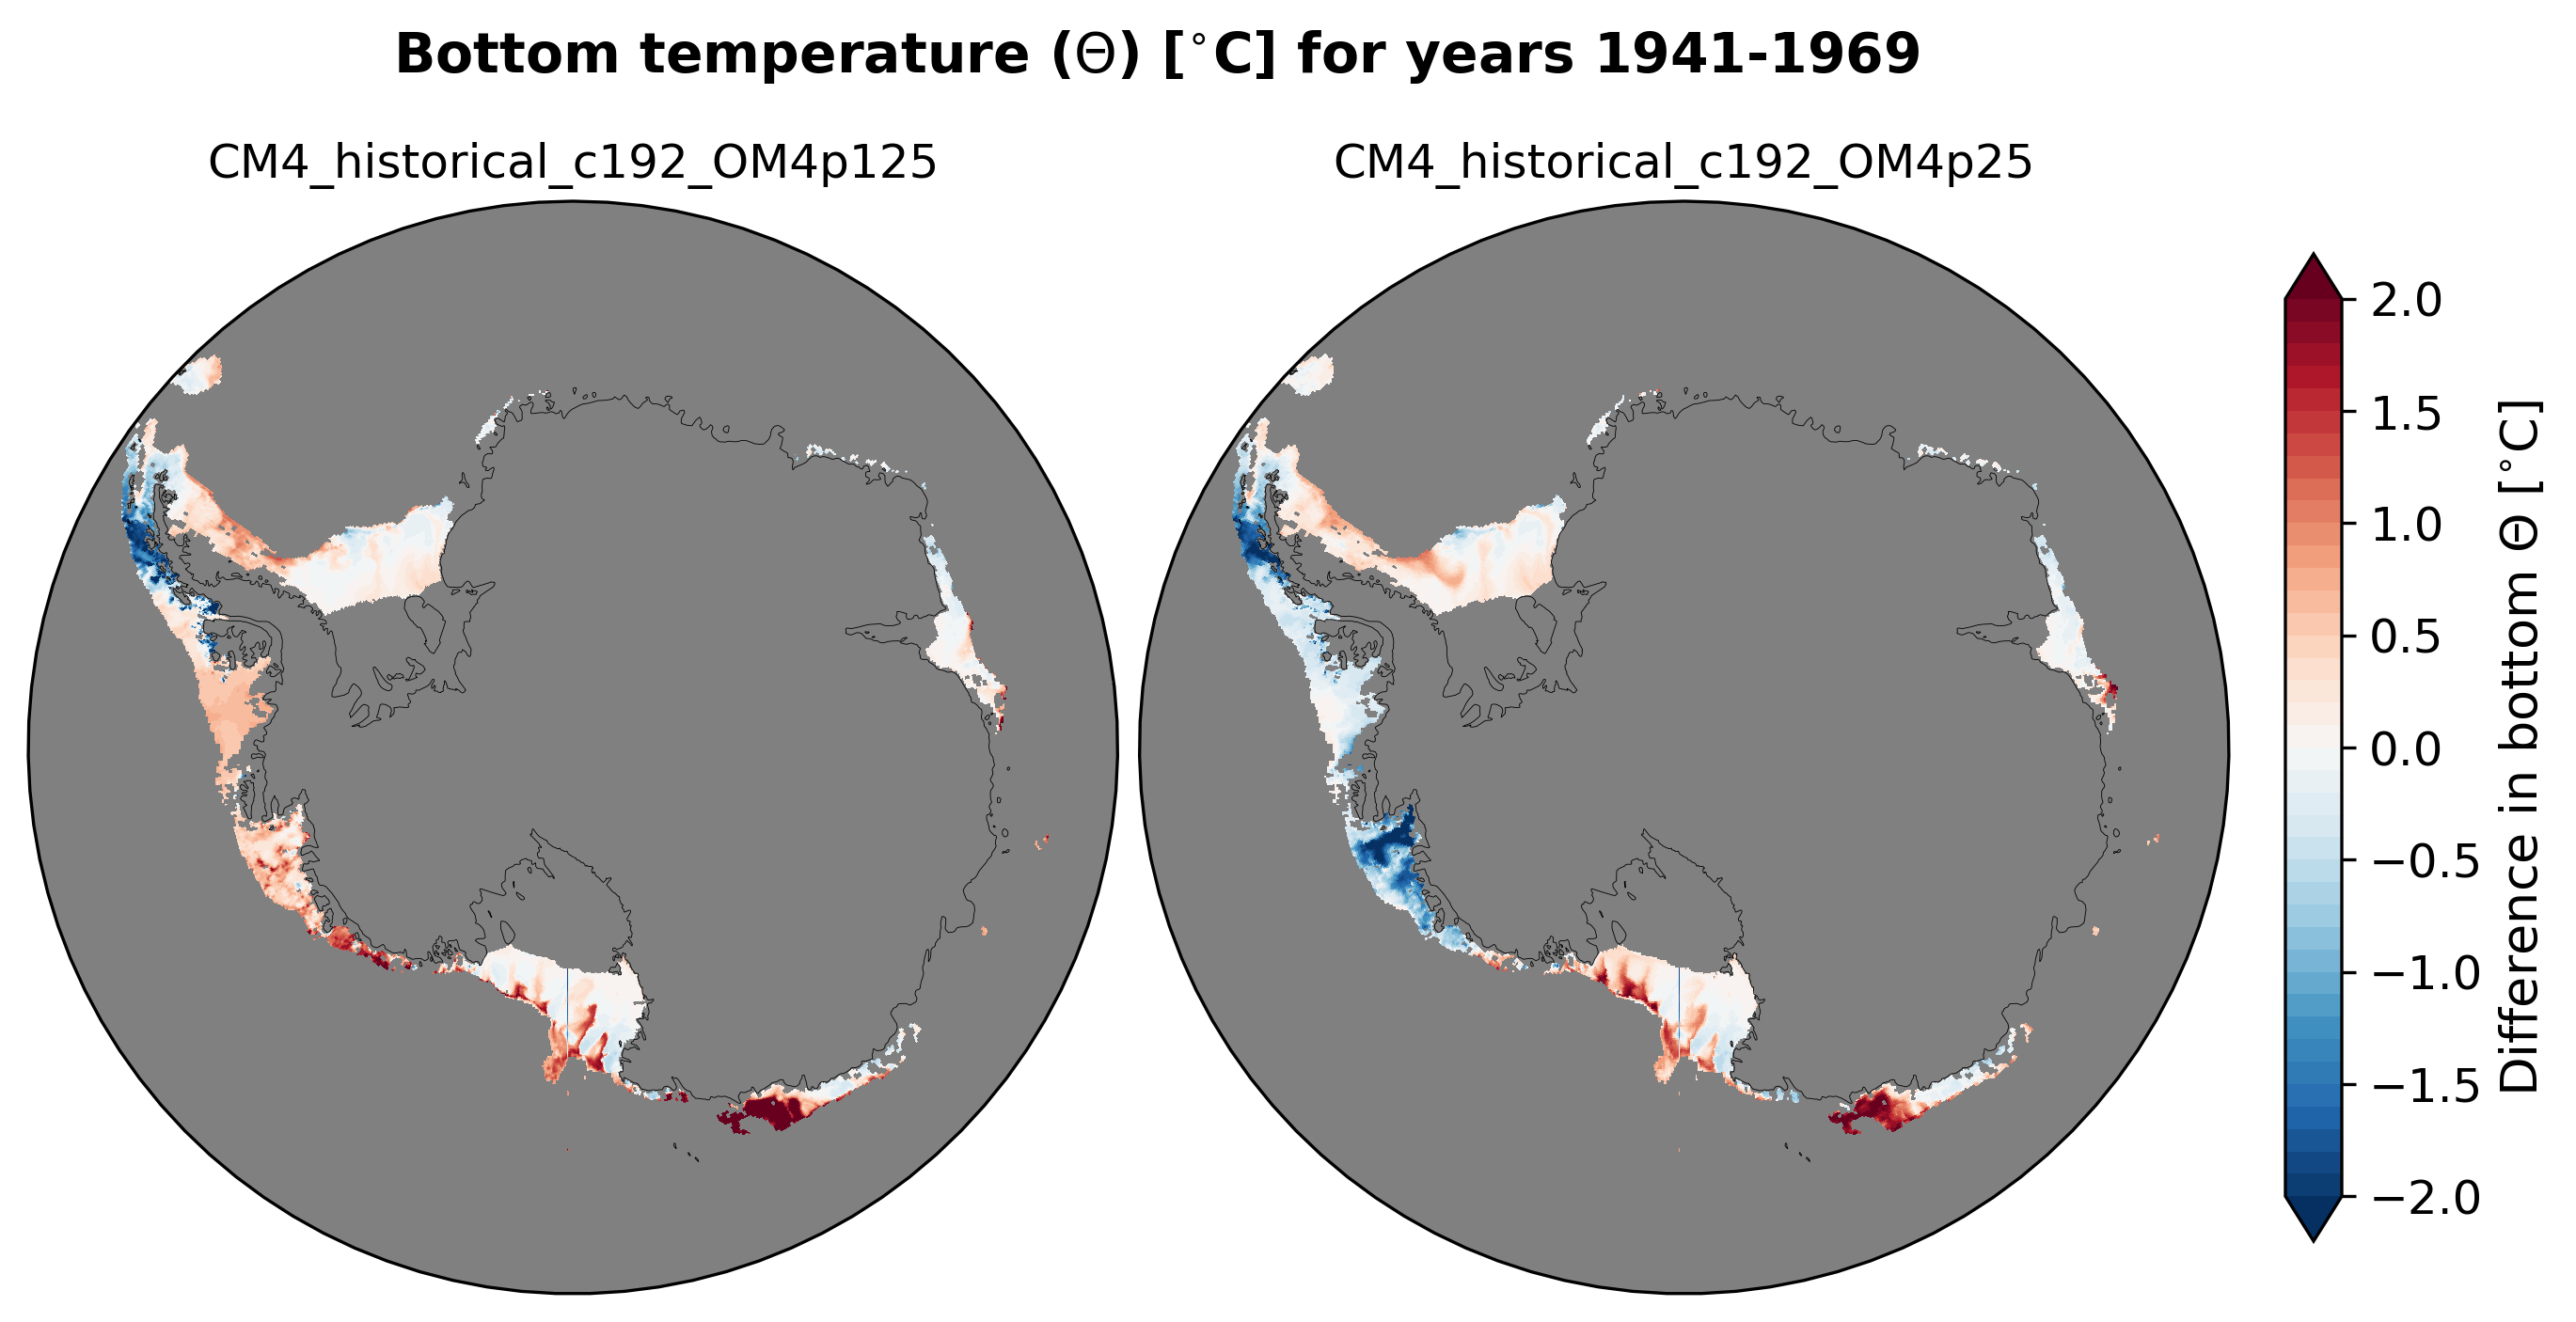

### Single plots

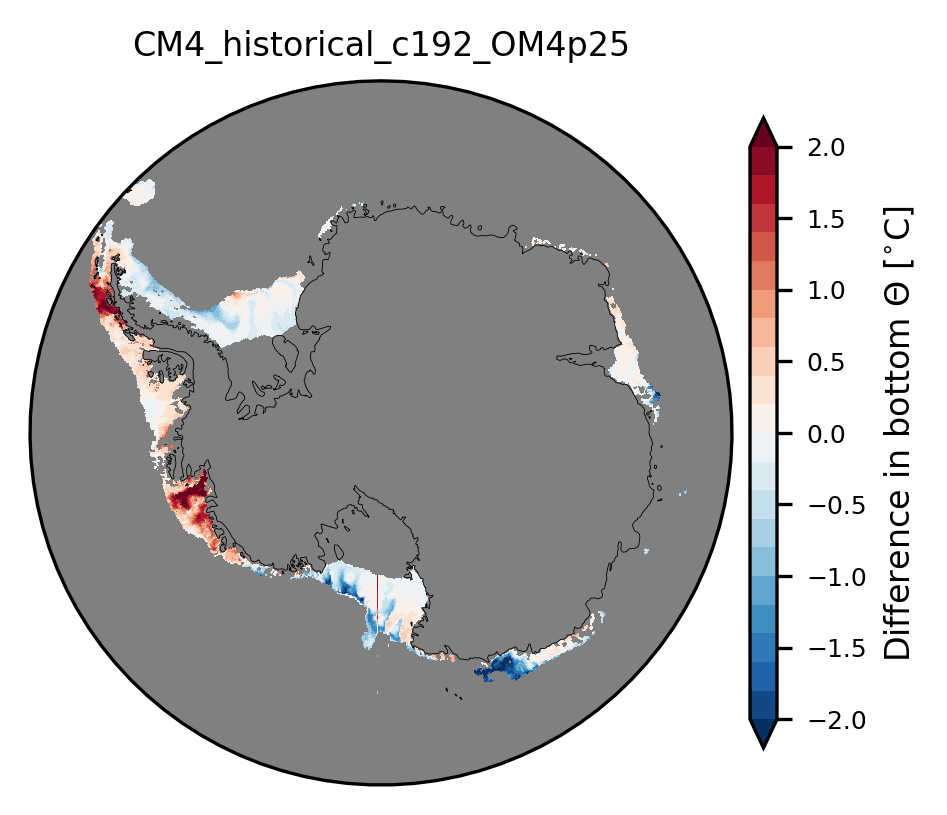

In [11]:
#cbstr = 'Difference in bottom $S_{A}$ [g kg$^{-1}$]'
cbstr = 'Difference in bottom $\Theta$ [$^{\circ}$C]'
da = ddict_diff[mod]['diff'][var]

fig = plt.figure(figsize=(3,3))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.coastlines(lw=0.2)
ax.set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

p =  da.plot(ax=ax, x='lon', y='lat', cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1], shading='auto', levels=21, extend='both',
             transform=cartopy.crs.PlateCarree(), add_colorbar=False)
cs = shlf_mask.fillna(0).plot.contour(ax=axes[i], x='x', y='y', linewidths=1, colors='k',transform=cartopy.crs.PlateCarree(), 
                                          add_labels=False,levels=[0,1,2])
ax.set_title(mod, fontsize=8)

# Add separate colorbar
cax = fig.add_axes([0.9, 0.15 , 0.03, 0.7])
cb = fig.colorbar(p, cax=cax, ticks=ticks, orientation='vertical', shrink=0.9, pad=0.02)
cb.set_label(cbstr, fontsize=8)
cb.ax.tick_params(labelsize=6)

#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

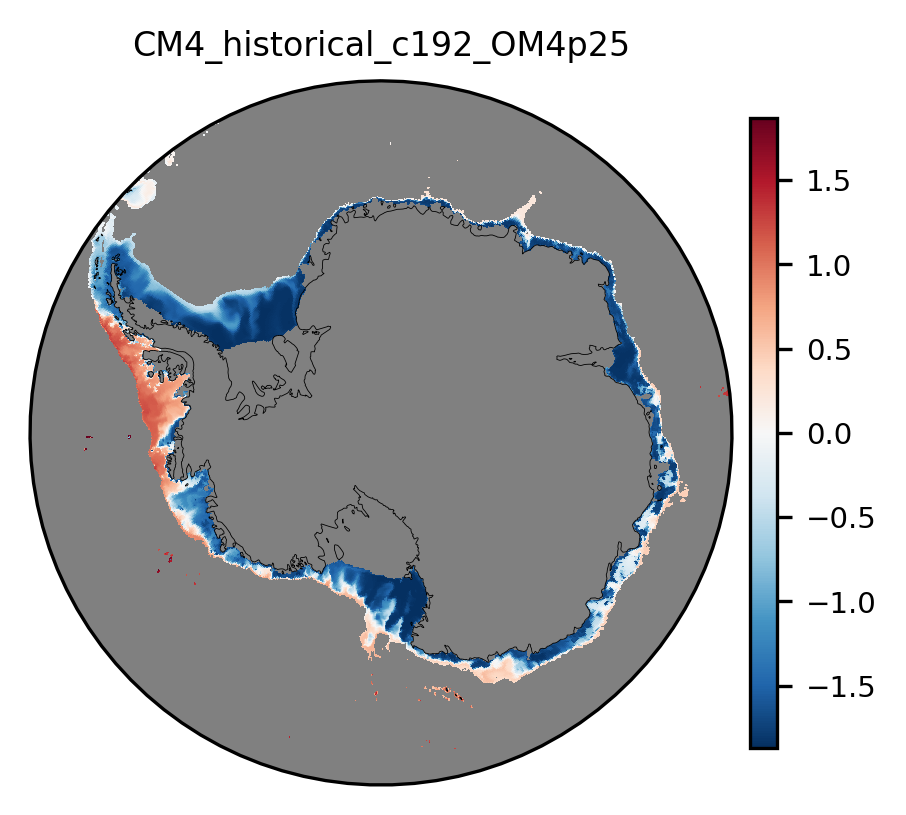

In [14]:
fig = plt.figure(figsize=(3,3))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)
ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.coastlines(lw=0.2)
ax.set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
p =  da.where(da.wet==1).plot(ax=ax, x='geolon', y='geolat', robust=True, shading='auto', 
                              transform=cartopy.crs.PlateCarree(), add_colorbar=False)
ax.set_title(mod, fontsize=8)
cax = fig.add_axes([0.9, 0.15 , 0.03, 0.7])
cb = fig.colorbar(p, cax=cax)
plt.show()

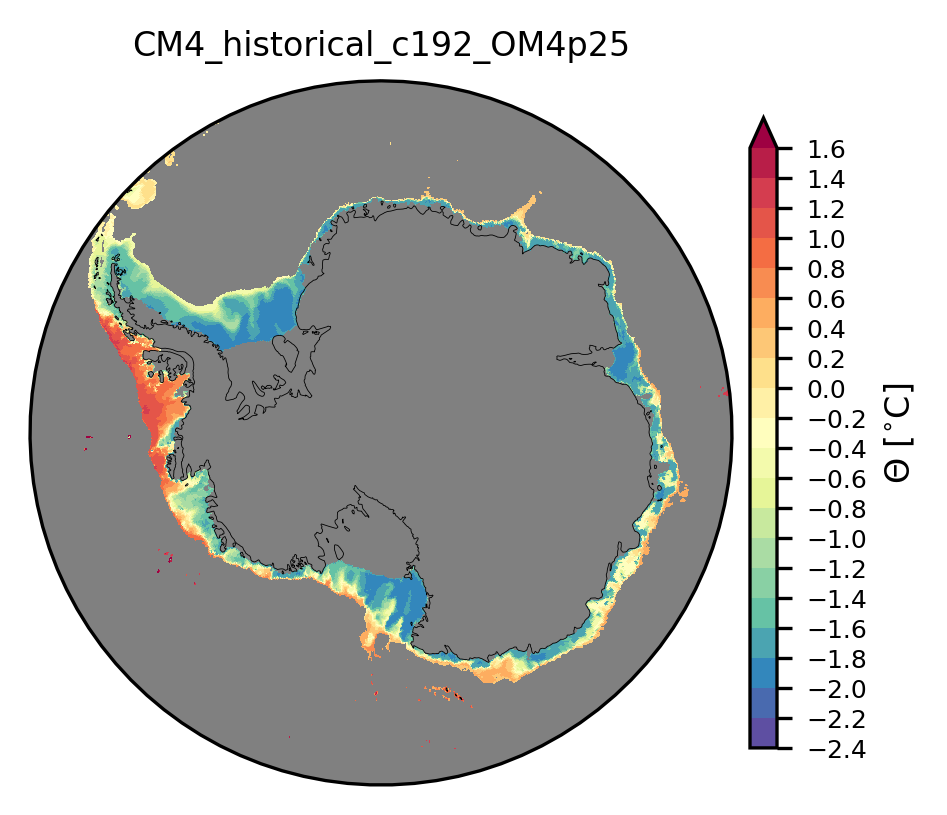

In [15]:
da = ddict[mod][var]

#cbstr = 'Bottom $S_{A}$ [g kg$^{-1}$]'
#vrange = [34.2, 34.9]
#ticks = np.arange(34.2,34.9,0.1)

cbstr = '$\Theta$ [$^{\circ}$C]'
vrange = [-2.4, 1.6]
ticks = np.arange(-2.4,1.8,0.2)
cmap = 'Spectral_r'
levels = 21

fig = plt.figure(figsize=(3,3))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.coastlines(lw=0.2)
ax.set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
p =  da.where(da.wet==1).plot(ax=ax, x='geolon', y='geolat', vmin=vrange[0], vmax=vrange[1], cmap=cmap, levels=levels, 
                              shading='auto', transform=cartopy.crs.PlateCarree(), add_colorbar=False)
#cs = shlf_mask.fillna(0).plot.contour(ax=ax, x='x', y='y', linewidths=1, colors='k',transform=cartopy.crs.PlateCarree(), 
#                                      add_labels=False,levels=[0,1,2])
ax.set_title(mod, fontsize=8)

# Add separate colorbar
cax = fig.add_axes([0.9, 0.15 , 0.03, 0.7])
cb = fig.colorbar(p, cax=cax, ticks=ticks, orientation='vertical', shrink=0.9, pad=0.02)
cb.set_label(cbstr, fontsize=8)
cb.ax.tick_params(labelsize=6)

#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

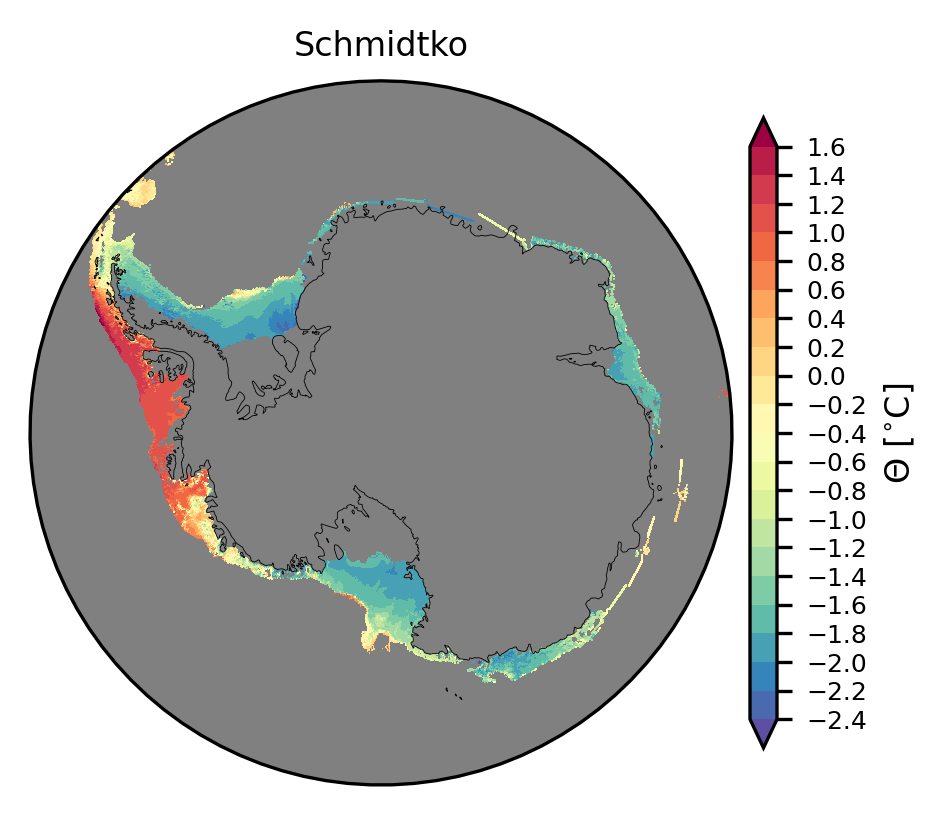

In [16]:
da = ddict[mod_ctr][var]

fig = plt.figure(figsize=(3,3))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.coastlines(lw=0.2)
ax.set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

p =  da.plot(ax=ax, x='lon', y='lat', vmin=vrange[0], vmax=vrange[1], cmap=cmap, levels=levels, 
             shading='auto', transform=cartopy.crs.PlateCarree(), add_colorbar=False)
ax.set_title(mod_ctr, fontsize=8)

# Add separate colorbar
cax = fig.add_axes([0.9, 0.15 , 0.03, 0.7])
cb = fig.colorbar(p, cax=cax, ticks=ticks, orientation='vertical', shrink=0.9, pad=0.02)
cb.set_label(cbstr, fontsize=8)
cb.ax.tick_params(labelsize=6)

#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

### 1-on-1 Comparison

In [20]:
#mod = 'CM4_historical_c192_OM4p25'
print(mod_ctr,mod)
labels = [mod_ctr, mod]
set_vrange = True

Schmidtko CM4_historical_c192_OM4p25


In [24]:
titel_str  = 'Temperature [$^{\circ}$C] for years %s'%(tprd if yr is None else yr)
vrange_var,vrange_dif = [-2.4, 1.6],[-2,2]
cmap_var,cmap_dif = 'Spectral_r','RdBu_r'
cbstr = ['[$^{\circ}$C]','$\Delta$ [$^{\circ}$C]']

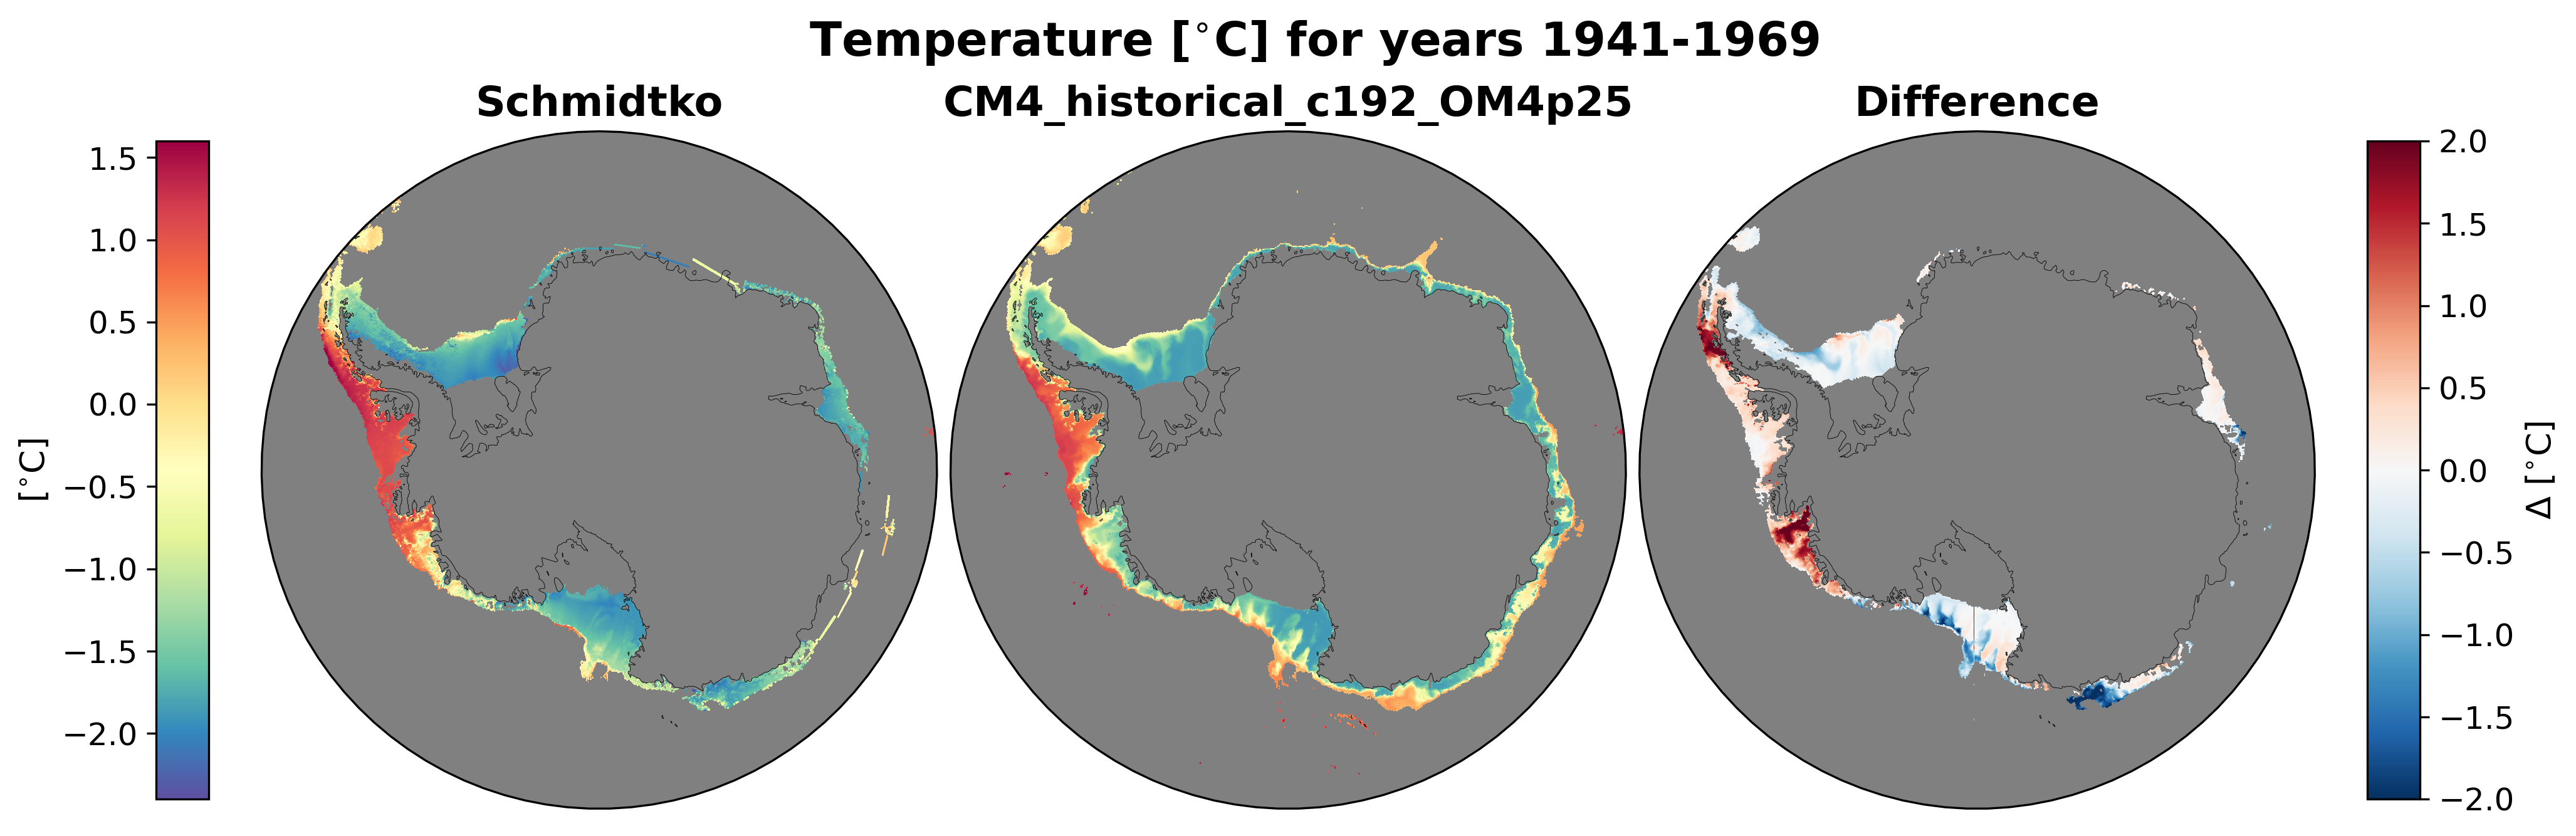

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), 
                         subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                         facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

for i, arr_name in enumerate(['ds1_orig','ds2_orig','diff']):
    
    da = ddict_diff[mod][arr_name][var]
    
    axes[i].coastlines(lw=0.2)
    axes[i].set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
    axes[i].set_boundary(circle, transform=axes[i].transAxes)
    
    if set_vrange:
        vrange = vrange_dif if arr_name=='diff' else vrange_var
        robust=False
    else:
        vrange = [None, None]
        robust=True
        
    cmap = cmap_dif if arr_name=='diff' else cmap_var
    
    p = da.plot(ax=axes[i], x='lon', y='lat', cmap=cmap, robust=robust, vmin=vrange[0], vmax=vrange[1], shading='auto',
                transform=cartopy.crs.PlateCarree(), add_colorbar=False)
    
    axes[i].set_title(labels[i] if i<2 else 'Difference',fontsize=16, fontweight='bold')
    
    if i==0:
        cax = fig.add_axes([0.06, 0.15 , 0.02, 0.7])
        cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.5, pad=0.2)
        cb.set_label(cbstr[0], fontsize=13)
        cb.ax.tick_params(labelsize=12)
        cax.yaxis.set_ticks_position('left')
        cax.yaxis.set_label_position('left')
    elif i==2:
        cax = fig.add_axes([0.9, 0.15 , 0.02, 0.7])
        cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.5, pad=0.2)
        cb.set_label(cbstr[1], fontsize=13)
        cb.ax.tick_params(labelsize=12)

fig.suptitle(titel_str,fontweight='bold',fontsize=18,y=0.98)
plt.show()

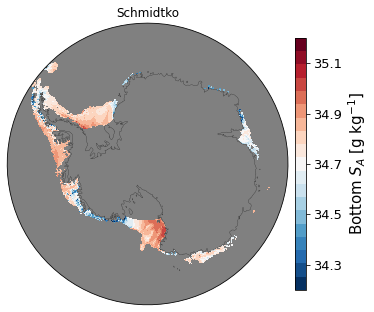

In [17]:
da = ddict_diff[mod]['ds2'][var]

fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.coastlines(lw=0.2)
ax.set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

p =  da.plot(ax=ax, x='lon', y='lat', vmin=34.2, vmax=35.2, cmap='RdBu_r', shading='auto', levels=20, extend='neither',
             transform=cartopy.crs.PlateCarree(), add_colorbar=False)
ax.set_title(mod, fontsize=12)

# Add separate colorbar
cax = fig.add_axes([0.9, 0.15 , 0.03, 0.7])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(34.3,35.3,0.2), orientation='vertical', shrink=0.9, pad=0.02)
cb.set_label(r'Bottom $S_{A}$ [g kg$^{-1}$]', fontsize=15)
cb.ax.tick_params(labelsize=13)
plt.show()

### Three-panel figure

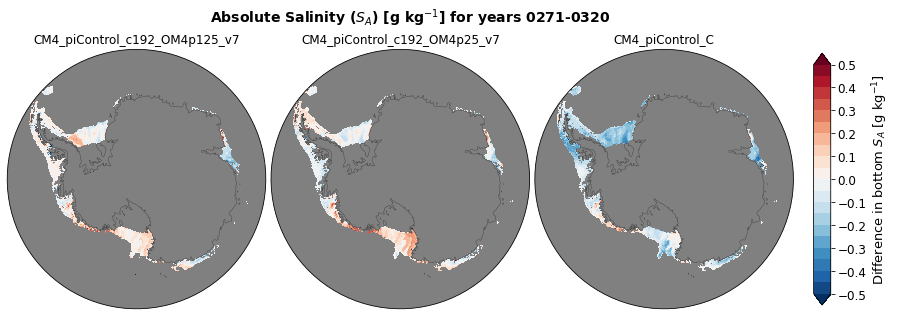

In [9]:
titel_str = titel_str = 'Absolute Salinity ($S_{A}$) [g kg$^{-1}$] for years %s'%(tprd if yr is None else yr)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), 
                         subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                         facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

for i, mod in enumerate(ddict_diff):
    
    da = ddict_diff[mod]['diff'][var]*(-1) # map differences as mod minus obs
    
    axes[i].coastlines(lw=0.2)
    axes[i].set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
    axes[i].set_boundary(circle, transform=axes[i].transAxes)
    p = da.plot(ax=axes[i], x='lon', y='lat', cmap='RdBu_r', vmin=-0.5, vmax=0.5, shading='auto',levels=21, extend='both',
                transform=cartopy.crs.PlateCarree(), add_colorbar=False)
    #cs = shlf_mask.fillna(0).plot.contour(ax=axes[i], x='x', y='y', linewidths=1, colors='k',transform=cartopy.crs.PlateCarree(), 
    #                                      add_labels=False,levels=[0,1,2])
    axes[i].set_title(mod, fontsize=12)
    
fig.suptitle(titel_str,fontweight='bold',fontsize=14,y=0.98)
cax = fig.add_axes([0.9, 0.15 , 0.017, 0.7])
cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=np.arange(-0.5,0.6,0.1), shrink=0.5, pad=0.2)
cb.set_label(r'Difference in bottom $S_{A}$ [g kg$^{-1}$]', fontsize=13)
cb.ax.tick_params(labelsize=12)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Four-panel figure

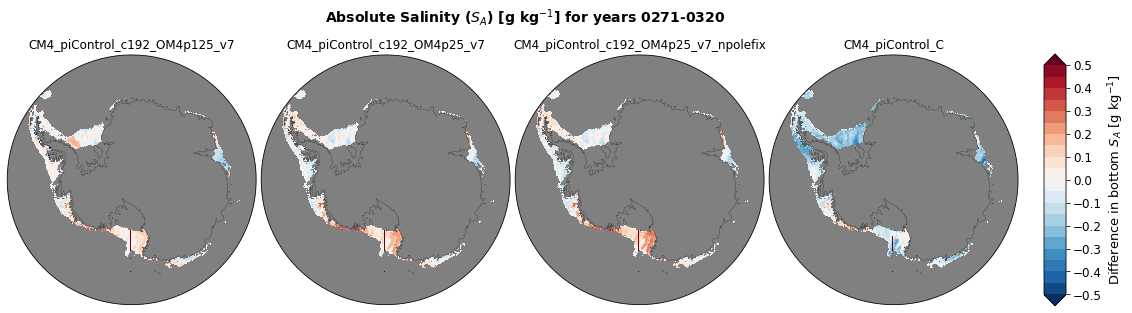

In [9]:
titel_str = titel_str = 'Absolute Salinity ($S_{A}$) [g kg$^{-1}$] for years %s'%(tprd if yr is None else yr)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,5), 
                         subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                         facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

for i, mod in enumerate(ddict_diff):
    
    da = ddict_diff[mod]['diff'][var]*(-1) # map differences as mod minus obs
    
    axes[i].coastlines(lw=0.2)
    axes[i].set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
    axes[i].set_boundary(circle, transform=axes[i].transAxes)
    p = da.plot(ax=axes[i], x='lon', y='lat', cmap='RdBu_r', vmin=-0.5, vmax=0.5, shading='auto',levels=21, extend='both',
                transform=cartopy.crs.PlateCarree(), add_colorbar=False)
    #cs = shlf_mask.fillna(0).plot.contour(ax=axes[i], x='x', y='y', linewidths=1, colors='k',transform=cartopy.crs.PlateCarree(), 
    #                                      add_labels=False,levels=[0,1,2])
    axes[i].set_title(mod, fontsize=12)
    
fig.suptitle(titel_str,fontweight='bold',fontsize=14,y=0.98)
cax = fig.add_axes([0.9, 0.15 , 0.017, 0.7])
cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=np.arange(-0.5,0.6,0.1), shrink=0.5, pad=0.05)
cb.set_label(r'Difference in bottom $S_{A}$ [g kg$^{-1}$]', fontsize=13)
cb.ax.tick_params(labelsize=12)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

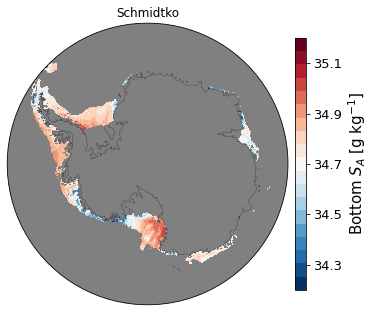

In [18]:
ddict_diff[mod]['ds2'].so

<xarray.DataArray 'so' (yh: 576, xh: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
    lon      (yh, xh) float32 -299.8 -299.2 -298.8 -298.2 ... 59.99 59.99 60.0
    lat      (yh, xh) float32 -77.91 -77.91 -77.91 -77.91 ... 65.39 65.18 64.97
Dimensions without coordinates: yh, xh
Attributes:
    units:      g/kg
    long_name:  Absolute Salinity

In [19]:
# Using 0.5 deg ESM4: mod_ctr = 'ESM4_piControl_D'
grid = xr.open_dataset('/home/Jan-erik.Tesdal/data/raw/ESM4_piControl_D/ocean_monthly/ocean_monthly.static.nc',use_cftime=True)

# Using 0.25 deg CM4: mod_ctr = 'CM4_piControl_C'
#grid = xr.open_dataset('/home/Jan-erik.Tesdal/data/raw/CM4_piControl_C/ocean_monthly/ocean_monthly.static.nc',use_cftime=True)

# Using 0.125 deg CM4: mod_ctr = 'CM4_piControl_C'
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/'
#grid = xr.open_dataset(rootdir+platfrom+'/pp/ocean_annual_z/ocean_annual_z.static.nc',use_cftime=True)

so_obs = xr.DataArray(ddict_diff[mod]['ds2'].so.values,coords=[grid.yh.values,grid.xh.values], dims=['y','x'])

In [20]:
ds_obs = so_obs.where(so_obs>0).to_dataset(name='bottom_so')
ds_obs['areacello'] = grid.areacello.rename({'xh':'x','yh':'y'})
ds_obs['wet'] = grid.wet.rename({'xh':'x','yh':'y'})

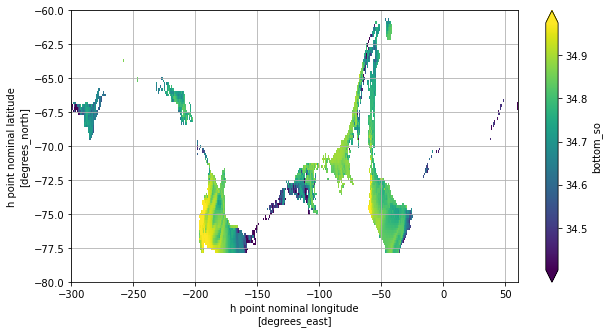

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
ds_obs.bottom_so.where(ds_obs.wet==1).plot(ax=ax,x='x',y='y',robust=True)
ax.set_ylim([-80, -60])
ax.grid(True)
plt.show()

In [21]:
ds_obs

<xarray.Dataset>
Dimensions:    (y: 1080, x: 1440)
Coordinates:
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
Data variables:
    bottom_so  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    areacello  (y, x) float32 ...
    wet        (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [22]:
ds_obs.to_netcdf('/work/jet/Schmidtko_Antarctic_shelf_data_bottom_salinity_05.nc', format='NETCDF4')

In [23]:
from compute import horizontal_mean

In [24]:
print('Spatial average:',horizontal_mean(ds_obs.bottom_so,ds_obs).values)

Spatial average: 34.77058


Spatial average: 34.77205


Spatial average: 34.77147


## Testing with single comparison

In [4]:
pp = 'ocean_annual_z'
tprd = '0041-0050'
var = 'so'
yr = '0050' # None 
# Odiv-209, Odiv-207, Odiv-206, Odiv-200, Odiv-191, Odiv-184
rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/' 

subdir1 = 'CM4_piControl_c192_OM4p125_v7' # Odiv-209
#subdir2 = 'CM4_piControl_c192_OM4p125_v6_alt1' # Odiv-200

platfrom = 'gfdl.ncrc4-intel18-prod-openmp'
data_path1 = os.path.join(rootdir,subdir1,platfrom,'pp',pp)+'/ts/annual/10yr/'+pp+'.'+tprd+'.'+var+'.nc'
grid_path1 = os.path.join(rootdir,subdir1,platfrom,'pp',pp)+'/'+pp+'.static.nc'
ds1 = xr.open_dataset(data_path1,use_cftime=True)
ds1_grid = xr.open_dataset(grid_path1,use_cftime=True)

#data_path2 = os.path.join(rootdir,subdir2,platfrom,'pp',pp)+'/ts/annual/10yr/'+pp+'.'+tprd+'.'+var+'.nc'
#grid_path2 = os.path.join(rootdir,subdir2,platfrom,'pp',pp)+'/'+pp+'.static.nc'
#ds2 = xr.open_dataset(data_path2,use_cftime=True)
#ds2_grid = xr.open_dataset(grid_path2,use_cftime=True)

data_path2 = '/work/jet/Schmidtko_Antarctic_shelf_data.nc'
print(data_path2)
ds2 = xr.open_dataset(data_path2,decode_times=False)

/work/jet/Schmidtko_Antarctic_shelf_data.nc


In [5]:
print(str(ds1.time.values[0])[:10],'to',str(ds1.time.values[-1])[:10])

0041-07-02 to 0050-07-02


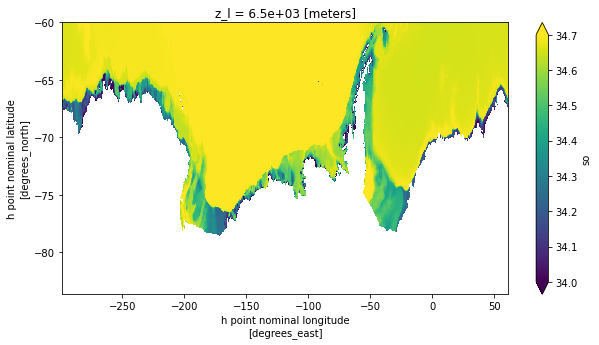

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
ds1[var].chunk({'time':1}).ffill('z_l').isel(z_l=-1).mean('time').plot(ax=ax, vmin=34, vmax=34.7)
ax.set_ylim([None, -60])
plt.show()

In [30]:
xr.set_options(keep_attrs=True)
p = xr.apply_ufunc(gsw.p_from_z, -ds1['z_l'], ds1_grid['geolat'], 0, 0, dask='parallelized')
sa = xr.apply_ufunc(gsw.SA_from_SP, ds1.so, p, ds1_grid['geolon'], ds1_grid['geolat'], dask='parallelized')

In [9]:
#ds = ds1[var].chunk({'time':1}).ffill('z_l').isel(z_l=-1).mean('time').to_dataset()
ds = sa.chunk({'time':1}).ffill('z_l').isel(z_l=-1).mean('time').to_dataset(name=var)
ds = ds.assign_coords({'geolon': ds1_grid['geolon'], 'geolat': ds1_grid['geolat']})

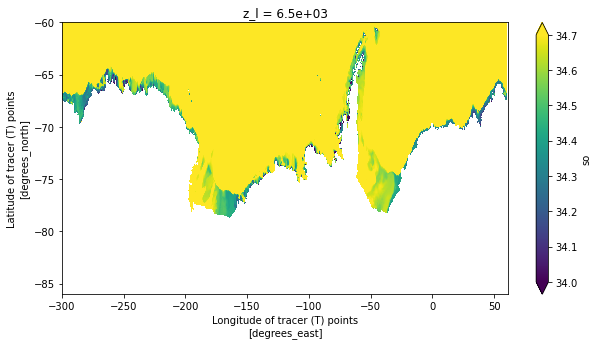

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ds.so.plot(ax=ax, x='geolon',y='geolat', vmin=34, vmax=34.7)
ax.set_ylim([None, -60])
plt.show()

In [32]:
#arr1 = ds1[var].chunk({'time':1}).ffill('z_l').isel(z_l=-1).mean('time').where(ds1_grid.geolat<north).where(ds1_grid.deptho<1000)
arr1 = sa.chunk({'time':1}).ffill('z_l').isel(z_l=-1).mean('time').where(ds1_grid.geolat<north).where(ds1_grid.deptho<1000).rename(var)
arr1 = xc.coord_util.associate_ocean_coords(arr1,ds1_grid)

In [35]:
arr1

<xarray.DataArray 'so' (yh: 2240, xh: 2880)>
dask.array<where, shape=(2240, 2880), dtype=float64, chunksize=(2240, 2880), chunktype=numpy.ndarray>
Coordinates:
  * xh         (xh) int64 1 2 3 4 5 6 7 8 ... 2874 2875 2876 2877 2878 2879 2880
  * yh         (yh) int64 1 2 3 4 5 6 7 8 ... 2234 2235 2236 2237 2238 2239 2240
    z_l        float64 6.5e+03
    geolon     (yh, xh) float32 ...
    geolat     (yh, xh) float32 -82.46 -82.46 -82.45 ... 64.17 64.11 64.06
    areacello  (yh, xh) float32 ...
    wet        (yh, xh) float32 ...
Attributes:
    long_name:      Sea Water Salinity
    units:          psu
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

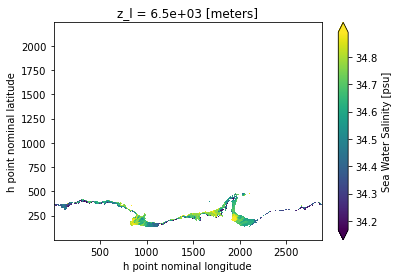

In [36]:
arr1.plot(robust=True)

In [37]:
#arr2 = ds2[var].isel(z_l=0).sel(time=yr).squeeze()
arr2 = ds2.sa.rename(var)

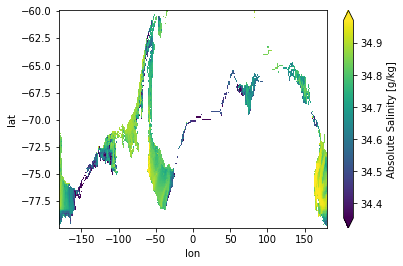

In [38]:
arr2.plot(robust=True)

In [39]:
ds1 = arr1.to_dataset()
ds2 = arr2.to_dataset()

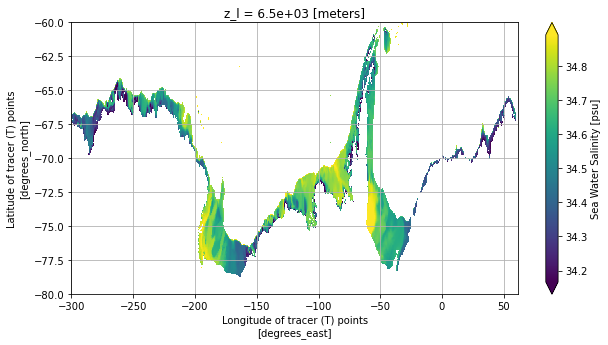

In [40]:
fig, ax = plt.subplots(figsize=(10,5))
ds1.so.plot(ax=ax,x='geolon',y='geolat',robust=True)
ax.set_ylim([-80, -60])
ax.grid(True)
plt.show()

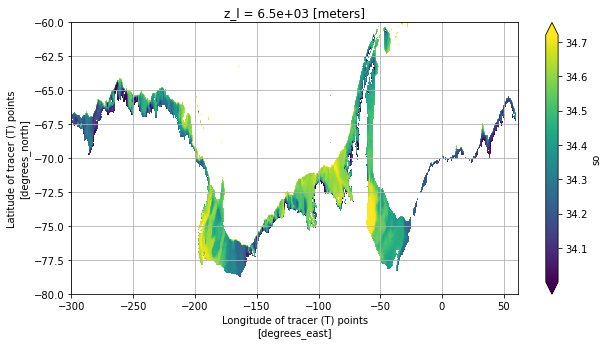

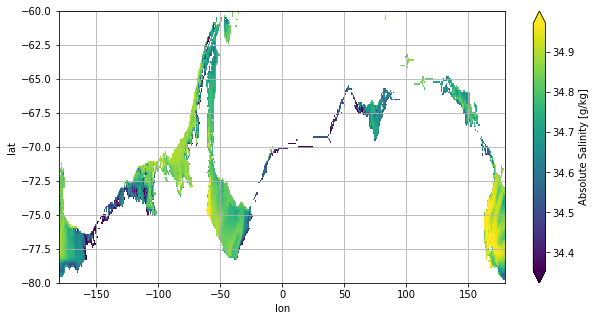

In [41]:
fig, ax = plt.subplots(figsize=(10,5))
ds2.so.plot(ax=ax,x='lon',y='lat',robust=True)
ax.set_ylim([-80, -60])
ax.grid(True)
plt.show()

In [42]:
results= xc.compare_datasets(ds1,ds2,varlist=[var])

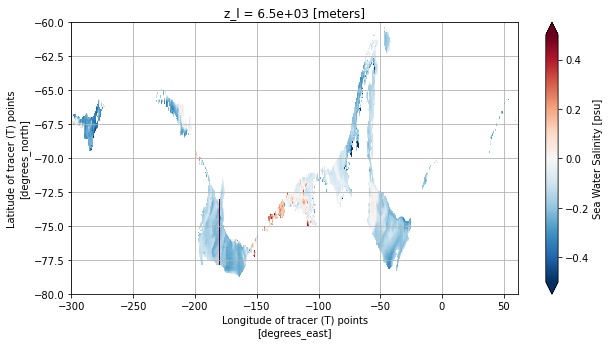

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
results['diff'].so.plot(ax=ax,x='lon',y='lat',vmin=-0.5, vmax=0.5, cmap='RdBu_r')
ax.set_ylim([-80, -60])
ax.grid(True)
plt.show()

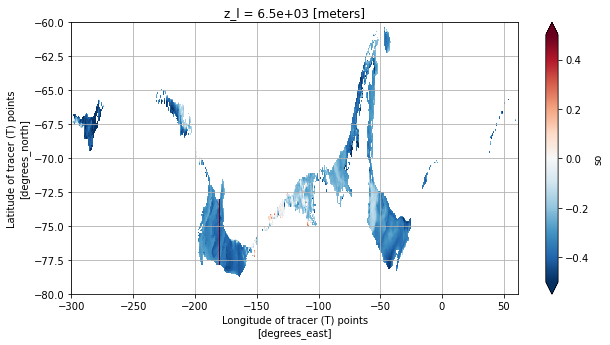

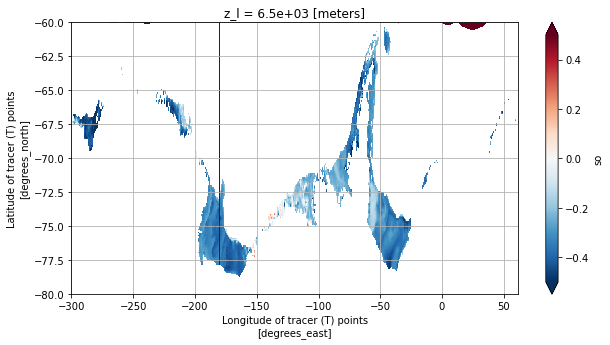

In [11]:
if yr is None:
    arr1 = ds1[var].isel(z_l=0).mean('time')
    arr2 = ds2[var].isel(z_l=0).mean('time')
else:
    arr1 = ds1[var].isel(z_l=0).sel(time=yr).squeeze()
    arr2 = ds2[var].isel(z_l=0).sel(time=yr).squeeze()
    
    
arr1 = xc.coord_util.associate_ocean_coords(arr1,ds1_grid)
arr2 = xc.coord_util.associate_ocean_coords(arr2,ds2_grid)

ds1 = arr1.to_dataset()
ds2 = arr2.to_dataset()

In [56]:
titel_str = 'Salinity [psu] for years %s'%(yr)
labels = ['Odiv-209', 'Odiv-200']
vrange_var,vrange_dif = [33.21, 34.58],[-0.61, 0.61]
cmap_var,cmap_dif = 'viridis','RdBu_r'
set_vrange = True

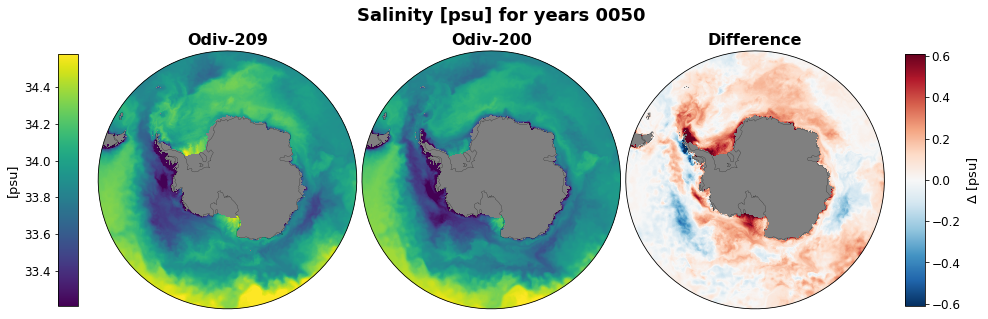

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), 
                         subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                         facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

for i, arr_name in enumerate(['ds1_orig','ds2_orig','diff']):
    
    da = results[arr_name][var]
    
    axes[i].coastlines(lw=0.2)
    axes[i].set_extent([-300, 60, -50, -90], cartopy.crs.PlateCarree())
    axes[i].set_boundary(circle, transform=axes[i].transAxes)
    
    if set_vrange:
        vrange = vrange_dif if arr_name=='diff' else vrange_var
        robust=False
    else:
        vrange = [None, None]
        robust=True
        
    cmap = cmap_dif if arr_name=='diff' else cmap_var
    
    p = da.plot(ax=axes[i], x='lon', y='lat', cmap=cmap, robust=robust, vmin=vrange[0], vmax=vrange[1], shading='auto',
                transform=cartopy.crs.PlateCarree(), add_colorbar=False)
    
    axes[i].set_title(labels[i] if i<2 else 'Difference',fontsize=16, fontweight='bold')
    
    if i==0:
        cax = fig.add_axes([0.06, 0.15 , 0.02, 0.7])
        cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.5, pad=0.2)
        cb.set_label('[psu]', fontsize=13)
        cb.ax.tick_params(labelsize=12)
        cax.yaxis.set_ticks_position('left')
        cax.yaxis.set_label_position('left')
    elif i==2:
        cax = fig.add_axes([0.9, 0.15 , 0.02, 0.7])
        cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.5, pad=0.2)
        cb.set_label('$\Delta$ [psu]', fontsize=13)
        cb.ax.tick_params(labelsize=12)

fig.suptitle(titel_str,fontweight='bold',fontsize=18,y=0.98)
plt.show()

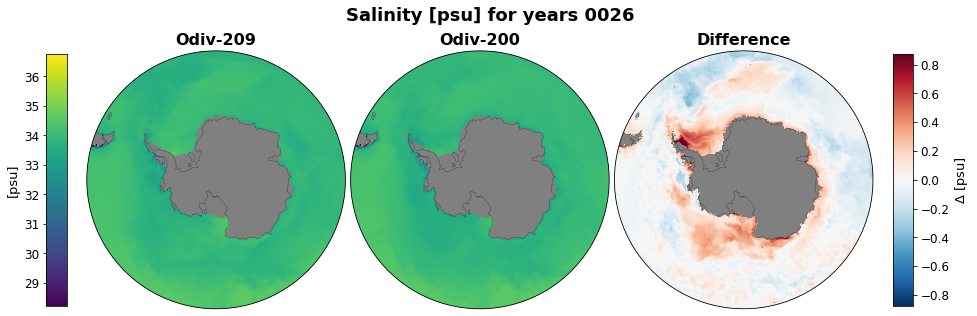

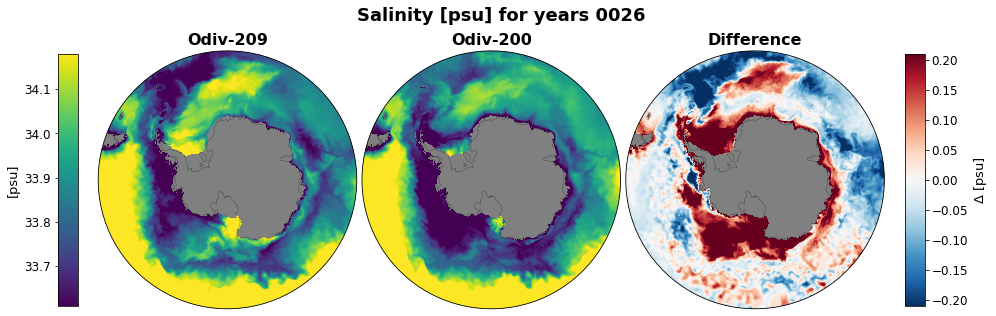

In [35]:
results = xc.Compare(arr1,arr2,verbose=True)

Performing Comparison on Arrays


In [37]:
print(results.difference.attrs)

{'bias': 0.0033990538280684506, 'rmse': 0.1464827653847319, 'rsquared': 0.9927068426731616}


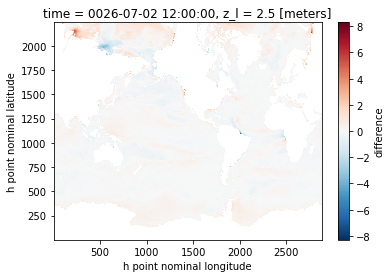

In [38]:
results.difference.plot()